In [1]:
import pandas as pd

## Load Dataset

In [138]:
data = {
    'name': ["Kang", "Kim", "Choi", "Park", "Yoon"],
    '짱절미': [True, False, False, False, False],
    '셀스타그램': [False, False, True, False, False],
    '우산': [False, False, False, False, False],
    'follower': [0, 0, 100, 210, 0],
    'like': [True, False, True, True, False]
}

data = pd.DataFrame(data)
data = data.set_index("name")

print(data.shape)
data.head()

(5, 5)


,짱절미,셀스타그램,우산,follower,like
name,,,,,
Kang,True,False,False,0,True
Kim,False,False,False,0,False
Choi,False,True,False,100,True
Park,False,False,False,210,True
Yoon,False,False,False,0,False


## Preprocessing

In [139]:
label_name = "like"
label_name

'like'

In [140]:
feature_names = data.columns.difference([label_name])
feature_names

Index(['follower', '셀스타그램', '우산', '짱절미'], dtype='object')

## Prerequisites

### Visualize Tree

In [5]:
import graphviz
from graphviz import Digraph

def display_node(dot, key, node):
    if node["leaf"] == True:
        probability = node['probability']
        probability = round(probability, 4)
        probability = str(probability)
        
        dot.node(key, probability)
    else:
        description = node['description']
        dot.node(key, description)
        
        if "left" in node:
            left_key = key + "L"
            display_node(dot, left_key, node['left'])
            dot.edge(key, left_key)

        if "right" in node:
            right_key = key + "R"
            display_node(dot, right_key, node['right'])
            dot.edge(key, right_key)

def display_tree(tree):
    dot = Digraph(comment='Decision Tree')

    display_node(dot, "Root", tree)

    return graphviz.Source(dot.source)

### Predict

In [6]:
def predict(data, node):
    if node['leaf'] == True:
        probability = node["probability"]
        result = dict(zip(data.index, len(data) * [probability]))
    else:
        condition = node['condition']
        
        left_data = data[condition(data)]
        left_result = predict(left_data, node['left'])
        
        right_data = data[~condition(data)]
        right_result = predict(right_data, node['right'])    
    
        return {**left_result, **right_result}

    return result

## Prior Knowledge

### Dictionary

In [8]:
vocabulary = {'apple':'사과', 'banana':'바나나'}
vocabulary

{'apple': '사과', 'banana': '바나나'}

In [9]:
vocabulary['apple']

'사과'

In [10]:
vocabulary['banana']

'바나나'

In [11]:
vocabulary = {
    'apple': {
        'ko':'사과',
        'jp':'ringo'
    }, 
    'banana': {
        'ko':'바나나',
        'jp':'banana'
    }
}

In [12]:
vocabulary

{'apple': {'ko': '사과', 'jp': 'ringo'}, 'banana': {'ko': '바나나', 'jp': 'banana'}}

In [13]:
vocabulary['apple']

{'ko': '사과', 'jp': 'ringo'}

In [14]:
vocabulary['apple']['ko']

'사과'

In [15]:
vocabulary['banana']['jp']

'banana'

In [17]:
vocabulary.keys()

dict_keys(['apple', 'banana'])

In [18]:
vocabulary.values()

dict_values([{'ko': '사과', 'jp': 'ringo'}, {'ko': '바나나', 'jp': 'banana'}])

In [21]:
keys = list(vocabulary.keys())
first_key = keys[0]

vocabulary[first_key]['ko']

'사과'

### 함수 (+익명함수, lamda)

In [23]:
def multiply(a, b):
    return a * b

multiply(3, 5)

15

In [26]:
multiply = lambda a,b : a * b

multiply(3,5)

15

### 재귀함수

In [35]:
def cycle(n):
    if n == 1:
        return [n]
    
    if n % 2 == 0:
        return [n] + cycle(n / 2)
    else:
        return [n] + cycle(n * 3 + 1)
    
print(cycle(1) == [1])
print(cycle(2) == [2,1])
print(cycle(3) == [3,10,5,16,8,4,2,1])
print(cycle(4) == [4,2,1])
print(cycle(5) == [5,16,8,4,2,1])

True
True
True
True
True


### Closure

In [36]:
def profile_generator(company):
    def user_generator(name):
        print(f"Name = {name}, Company = {company}")
    
    return user_generator

In [38]:
generator = profile_generator('DS School')
generator

<function __main__.profile_generator.<locals>.user_generator(name)>

In [40]:
generator('김광섭')

Name = 김광섭, Company = DS School


## Implement a Decision Tree

### Make Conditions

In [141]:
def binary_condition(data, feature_name, value):
    return data[feature_name] == value

def continuous_condition(data, feature_name, value):
    return data[feature_name] < value

def make_condition(method, feature_name, value):
    def call_condition(data):
        return method(data, feature_name, value)

    return call_condition

In [8]:
condition = make_condition(binary_condition, "짱절미", True)
data[condition(data)]

,짱절미,셀스타그램,우산,like
name,,,,
Kang,True,False,False,True


In [9]:
condition = make_condition(binary_condition, "셀스타그램", True)
data[condition(data)]

,짱절미,셀스타그램,우산,like
name,,,,
Choi,False,True,False,True


In [161]:
def make_condition_list(data, feature_names):
    condition_list = {}
    
    for feature_name in feature_names:
        if data[feature_name].dtype == 'bool':
            description = f"{feature_name} == True"
            condition = make_condition(binary_condition, feature_name, True)
            
            condition_list[description] = condition        
        else:
            value_list = data[feature_name].unique()
            value_list.sort()
            
            value_list = value_list[1:]
            
            for value in value_list:
                description = f"{feature_name} < {value}"
                condition = make_condition(continuous_condition, feature_name, value)
                
                condition_list[description] = condition
    
    return condition_list

In [162]:
make_condition_list(data, feature_names)

{'follower < 100': <function __main__.make_condition.<locals>.call_condition(data)>,
 'follower < 210': <function __main__.make_condition.<locals>.call_condition(data)>,
 '셀스타그램 == True': <function __main__.make_condition.<locals>.call_condition(data)>,
 '우산 == True': <function __main__.make_condition.<locals>.call_condition(data)>,
 '짱절미 == True': <function __main__.make_condition.<locals>.call_condition(data)>}

### Evaluate Gini Impurity

$$
{\displaystyle I_{G}(p)=\sum _{i=1}^{J}p_{i}(1-p_{i})=p_{t}(1-p_{t}) + p_{f}(1-p_{f})}
$$

In [101]:
def evaluate_gini_impurity(data, label_name):
    if len(data) == 0:
        return 0
    true_probability = data[label_name].mean()
    false_probability = 1 - true_probability
    
    true_gini_impurity = true_probability * (1 - true_probability)
    false_gini_impurity = false_probability * (1 - false_probability)
    
    gini_impurity = true_gini_impurity + false_gini_impurity
    return gini_impurity

In [100]:
evaluate_gini_impurity(data, label_name)

0.48

In [104]:
def evaluate_average_gini_evaluate(data, condition, label_name):
    true_data = data[condition(data)]
    false_data = data[~condition(data)]
    
    true_impurity = evaluate_gini_impurity(true_data, label_name)
    false_impurity = evaluate_gini_impurity(false_data, label_name)
    
    gini_impurity = len(true_data) * true_impurity + len(false_data) * false_impurity
    gini_impurity = gini_impurity / len(data)
    
    return gini_impurity

In [105]:
condition = make_condition(binary_condition, "짱절미", True)
evaluate_average_gini_evaluate(data, condition, label_name)

0.4

In [106]:
condition = make_condition(binary_condition, "셀스타그램", True)
evaluate_average_gini_evaluate(data, condition, label_name)

0.4

In [158]:
condition = make_condition(continuous_condition, "follower", 100)
evaluate_average_gini_evaluate(data, condition, label_name)

0.26666666666666666

In [153]:
def find_best_condition(data, condition_list, label_name):
    best_gini_impurity = 0.51
    best_condition = None
    best_description = None
    
    for description, condition in condition_list.items():
        gini_impurity = evaluate_average_gini_evaluate(data, condition, label_name)
        
        if gini_impurity < best_gini_impurity:
            best_gini_impurity = gini_impurity
            best_description = description
            best_condition = condition
            
    return best_gini_impurity, best_description, best_condition

In [154]:
condition_list = make_condition_list(data, feature_names)
    
find_best_condition(data, condition_list, label_name)

(0.26666666666666666,
 'follower < 100',
 <function __main__.make_condition.<locals>.call_condition(data)>)

### Make a Tree

0
1
2
2
1
2
2


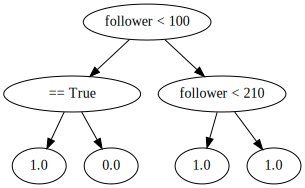

In [163]:
min_sample_split = 0
max_depth = 5

def make_node(data, condition_list, current_gini, current_depth):
    condition = len(condition_list) != 0
    sample = (len(data) >= min_sample_split)
    depth = (max_depth == None) or (current_depth < max_depth)
    print(current_depth)
   
    if condition and sample and depth:
        gini, description, condition = find_best_condition(data, condition_list, label_name)
        
        node = {'leaf' : False, 'description': description, 'condition': condition}
            
        left_data = data[condition(data)]
        right_data = data[~condition(data)]
              
        if gini < current_gini and len(left_data) > 0 and len(right_data) > 0:
            del condition_list[description]
            node['left'] = make_node(left_data, condition_list.copy(), gini, current_depth+1)
            node['right'] = make_node(right_data, condition_list.copy(), gini, current_depth+1)             
       
            return node

    probability = data[label_name].mean()
    node = {'leaf' : True, 'probability': probability}

    return node

def make_tree(data):
    tree = {}

    condition_list = make_condition_list(data, feature_names)
    
    tree = make_node(data, condition_list, current_gini=0.51, current_depth=0)
    
    return tree

tree = make_tree(data)

display_tree(tree)